In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm, linear_model
from sympy import *
from ipywidgets import interact, FloatLogSlider
from IPython.display import Latex, Markdown, display

In [2]:
X, y = datasets.make_blobs(random_state=1, centers=2)
X = X.tolist() + [[-3.8, 1], [-4, -0.3]]
X = np.array(X)
y = y.tolist() + [0, 1]
y = np.array(y)

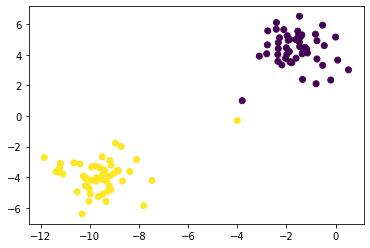

In [3]:
plt.scatter(*X.T, c=y)

In [4]:
x, y1 = symbols('x y')
W = MatrixSymbol('W', 2, 1)

In [5]:
@interact(b0=(-5,5,0.1), b1=(-10,10,0.1), b2=(-10,10,0.1))
def svv(b0=-0.1, b1=-0.1, b2=-1.3):
    if b1 == 0:
        b1 += 1e-8
    if b2 == 0:
        b2 += 1e-8
    coef_ = np.array([[b1, b2]])
    intercept_ = np.array([b0])
    a = Line((coef_ @ [x, y1] + intercept_)[0])
    plus = Line(Eq((coef_ @ [x, y1] + intercept_)[0], 1))
    minus = Line(Eq((coef_ @ [x, y1] + intercept_)[0], -1))
    
    
    # display(Latex(f"Weight vector: $W = {latex(Matrix(coef_))}$"))
    # display(Latex(f"Length of weight vector: $||W||={np.linalg.norm(coef_)}$"))
    a.p1.coordinates

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(*X.T, c=y)
    plt.axline(np.array(a.p1.coordinates, float), np.array(a.p2.coordinates, float), color='green', label='$w^T X + b = 0$')
    plt.axline(np.array(plus.p1.coordinates, float), np.array(plus.p2.coordinates, float), color='red', label='$w^T X + b = 1$')
    plt.axline(np.array(minus.p1.coordinates, float), np.array(minus.p2.coordinates, float), color='blue', label='$w^T X + b = -1$')
    plt.legend()
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')
    plt.title("Drawing a hyperplane that divides space into two halves")
    
    
    coef_ = np.array([[b1, b2]]) * 0.326
    intercept_ = np.array([b0]) * 0.326
    a = Line((coef_ @ [x, y1] + intercept_)[0])
    plus = Line(Eq((coef_ @ [x, y1] + intercept_)[0], 1))
    minus = Line(Eq((coef_ @ [x, y1] + intercept_)[0], -1))
    
    # display(Latex("Getting the same decision boundary is possible but [-1, 1] changes (on the right)"))
    # display(Latex(f"Weight vector: $W = {latex(Matrix(coef_))}$"))
    # display(Latex(f"Length of weight vector: $||W||={np.linalg.norm(coef_)}$"))
    plt.subplot(1, 2, 2)
    plt.scatter(*X.T, c=y)
    plt.axline(np.array(a.p1.coordinates, float), np.array(a.p2.coordinates, float), color='green', label='$w^T X + b = 0$')
    plt.axline(np.array(plus.p1.coordinates, float), np.array(plus.p2.coordinates, float), color='red', label='$w^T X + b = 1$')
    plt.axline(np.array(minus.p1.coordinates, float), np.array(minus.p2.coordinates, float), color='blue', label='$w^T X + b = -1$')
    plt.legend()
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')
    plt.title("Drawing a hyperplane that divides space into two halves")

interactive(children=(FloatSlider(value=-0.1, description='b0', max=5.0, min=-5.0), FloatSlider(value=-0.1, de…

Neden +1 ve -1'i de gosterdik?

## SVM kayip fonksiyonu Hinge

In [6]:
L = Function('L')
h = Function('h')
Eq(L(h(x)), Max(0, 1 - h(x)*y1))

Eq(L(h(x)), Max(0, -y*h(x) + 1))

Lojistik regresyonun aksine, $h(x)$ $[0, 1]$ arasinda kisitli olmayip tum reel sayi degerlerini alabilmektedir.

In [7]:
Reals.contains(h(x))

(-oo < h(x)) & (h(x) < oo)

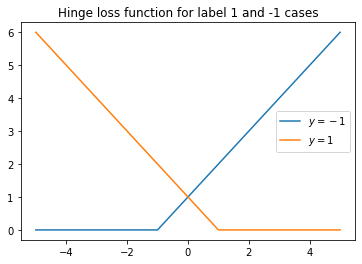

In [8]:
t = np.linspace(-5,5,1000)

p = -1
plt.plot(t, np.where(1 - t*p <= 0, 0, 1 - t*p), label=f'$y={p}$')
p = 1
plt.plot(t, np.where(1 - t*p <= 0, 0, 1 - t*p), label=f'$y={p}$')
plt.legend()
plt.title("Hinge loss function for label 1 and -1 cases");


Buna gore, pozitif sinif icin $w^T X + b >= 1$ ya da negatif sinif icin $w^T X + b <= -1$ oldugunda herhangi bir maliyet cikmiyor.

**Hatirlatma:** Lojistik regresyonda karar sinirindan uzak ve dogru tasniflendirilmis noktalar az da olsa hala maliyete etki etmektedir. 

Lojistik regresyonun, pozitif bir sinif icin logit degeri olarak 20 verdigini dusunelim.

In [9]:
p = 1. / (1. + np.exp(-20))
p

0.9999999979388463

In [10]:
-np.log(p)

2.0611536942919273e-09

Kucuk de olsa bu nokta icin maliyet gormekteyiz.

## SVM optimizasyon amac fonksiyonu

$$\min_\theta{C \sum^{m}_{i=1}{y_i Hinge(h(x_i)) + (1 - y_i) Hinge(h(x_i))}} + \frac{1}{2} ||W||^2$$

$$h(x_i) = W^T x_i $$

Amac fonksiyonunda goruldugu uzere, "misclassification" agirligi $C$ buyudukce model tasniflendirme hatasini azaltmaya calisacak, kuculdukce genelleme kabiliyetini artirmaya calisacaktir.

In [11]:
def hinge(y_true, decision):
    yt = (y_true - 0.5) * 2.0
    return np.where(1 - decision*yt <= 0, 0, 1 - decision*yt)

In [12]:
@interact
def svmviz(C=FloatLogSlider(value=1.0, base=10, min=-5, max=3, step=1)):
    m = svm.SVC(C=C, kernel='linear')

    m.fit(X, y)
    
    coef = m.coef_.copy()
    if coef[0, 0] == 0:
        coef[0, 0] = 1e-8
    a =Line((coef @ [x, y1] + m.intercept_)[0])
    plus = Line(Eq((coef @ [x, y1] + m.intercept_)[0], 1))
    minus = Line(Eq((coef @ [x, y1] + m.intercept_)[0], -1))
    
    losses = hinge(y, m.decision_function(X))
    a.p1.coordinates

    plt.figure(figsize=(12, 8))
    plt.scatter(*X.T, c=np.log(losses + 1e-8))
    plt.colorbar().set_label("Log-Loss per sample")
    plt.axline(np.array(a.p1.coordinates, float), np.array(a.p2.coordinates, float), color='green', label='$w^T X + b = 0$')
    plt.axline(np.array(plus.p1.coordinates, float), np.array(plus.p2.coordinates, float), color='red', label='$w^T X + b = 1$')
    plt.axline(np.array(minus.p1.coordinates, float), np.array(minus.p2.coordinates, float), color='blue', label='$w^T X + b = -1$')
    plt.legend()
    plt.title("Which samples cause error?")

interactive(children=(FloatLogSlider(value=1.0, description='C', max=3.0, min=-5.0, step=1.0), Output()), _dom…

Daha fazla ornegin hata fonksiyonuna katilmasi daha genel bir sinir hatti verecektir.

In [13]:
def svmi_ciz():
    coef = m.coef_.copy()
    if coef[0, 0] == 0:
        coef[0, 0] = 1e-8
    a =Line((coef @ [x, y1] + m.intercept_)[0])
    plus = Line(Eq((coef @ [x, y1] + m.intercept_)[0], 1))
    minus = Line(Eq((coef @ [x, y1] + m.intercept_)[0], -1))
    plt.scatter(*X.T, c=y)
    plt.axline(np.array(a.p1.coordinates, float), np.array(a.p2.coordinates, float), color='green', label='$w^T X + b = 0$')
    plt.axline(np.array(plus.p1.coordinates, float), np.array(plus.p2.coordinates, float), color='red', label='$w^T X + b = 1$')
    plt.axline(np.array(minus.p1.coordinates, float), np.array(minus.p2.coordinates, float), color='blue', label='$w^T X + b = -1$')
    plt.legend()
    plt.title("SVM's decision boundary")

SVM'in ogrendigi agirliklar icin $h(x)$'e bazi ornekler:

In [14]:
m = svm.LinearSVC()
m.fit(X, y)

LinearSVC()

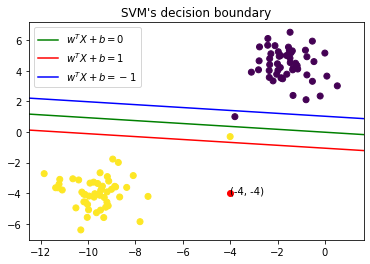

In [15]:
svmi_ciz()
plt.scatter(-4, -4, color='red')
plt.text(-4, -4, "(-4, -4)");

In [16]:
m.decision_function([[-4, -4]])

array([4.18698793])

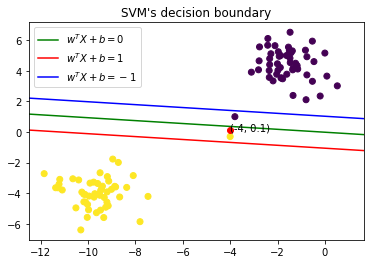

In [17]:
svmi_ciz()
plt.scatter(-4, 0.1, color='red')
plt.text(-4, 0.1, "(-4, 0.1)");

In [18]:
m.decision_function([[-4, 0.1]])

array([0.25261461])

In [19]:
hinge(1, m.decision_function([[-4, 0.1]]))

array([0.74738539])

In [20]:
hinge(-1, m.decision_function([[-4, 0.1]]))

array([1.75784384])

Karar fonksiyonunun degerinden ve karar sinirina yakinligindan da anlasilacagi uzere, ikinci sorgu noktasinin pozitif sinifa ait oldugundan daha az eminiz.

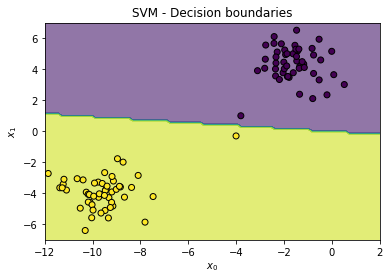

In [21]:
xx, yy = np.meshgrid(np.linspace(-12, 2, 100), np.linspace(-7, 7, 100))

plt.contourf(xx, yy, m.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape), alpha=0.6)
plt.scatter(*X.T, c=y, edgecolors='black')
plt.title('SVM - Decision boundaries')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$');

## Lojistik regresyon ile iliski

In [22]:
log = linear_model.LogisticRegression(C=.1).fit(X, y)

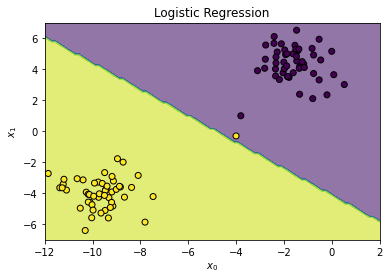

In [23]:
plt.contourf(xx, yy, log.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape), alpha=0.6)
plt.scatter(*X.T, c=y, edgecolors='black')
plt.title("Logistic Regression")
plt.xlabel('$x_0$')
plt.ylabel('$x_1$');

Tum orneklerin hataya katildigi lojistik regresyonda daha genel bir hattin cizildigini goruyoruz.

In [24]:
m = svm.SVC(C=10, kernel='linear')
m.fit(X, y)

SVC(C=10, kernel='linear')

No handles with labels found to put in legend.


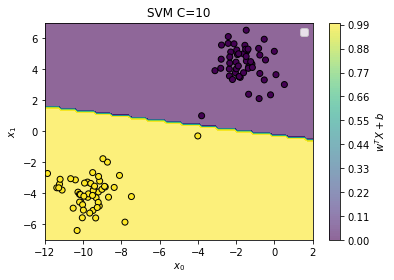

In [25]:
plt.contourf(xx, yy, m.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape), alpha=0.6, levels=100)
plt.colorbar().set_label('$w^T X + b$')
plt.scatter(*X.T, c=y, edgecolors='black')
plt.legend()
plt.title('SVM C=10')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$');


In [26]:
m.dual_coef_

array([[-1.15606885,  1.15606885]])

In [27]:
m = svm.SVC(C=.1, kernel='linear')
m.fit(X, y)

SVC(C=0.1, kernel='linear')

No handles with labels found to put in legend.


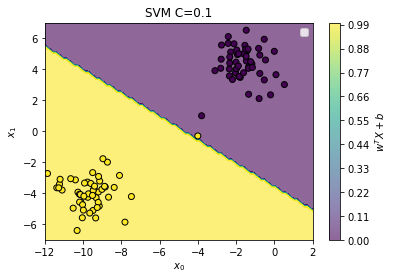

In [28]:
plt.contourf(xx, yy, m.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape), alpha=0.6, levels=100)
plt.colorbar().set_label('$w^T X + b$')
plt.scatter(*X.T, c=y, edgecolors='black')
plt.legend()
plt.title(f'SVM C={m.C}')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$');


In [29]:
m.dual_coef_

array([[-0.01739154, -0.1       ,  0.01739154,  0.1       ]])

## Destek vektorleri

Modele ismini veren "Support vectors" - destek vektorleri, kendisi icin hatanin 0 olmadigi dolayisiyla sinir cizimine katkida bulunan ornekledir.

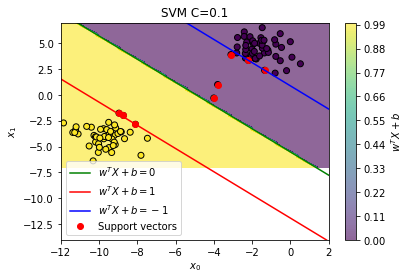

In [30]:
m = svm.SVC(C=0.01, kernel='linear')
m.fit(X, y)
a = Line((m.coef_ @ [x, y1] + m.intercept_)[0])

plus = Line(Eq((m.coef_ @ [x, y1] + m.intercept_)[0], 1))
minus = Line(Eq((m.coef_ @ [x, y1] + m.intercept_)[0], -1))


plt.contourf(xx, yy, m.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape), alpha=0.6, levels=100)
plt.colorbar().set_label('$w^T X + b$')
plt.scatter(*X.T, c=y, edgecolors='black')
plt.axline(np.array(a.p1.coordinates, float), np.array(a.p2.coordinates, float), color='green', label='$w^T X + b = 0$')
plt.axline(np.array(plus.p1.coordinates, float), np.array(plus.p2.coordinates, float), color='red', label='$w^T X + b = 1$')
plt.axline(np.array(minus.p1.coordinates, float), np.array(minus.p2.coordinates, float), color='blue', label='$w^T X + b = -1$')
plt.legend()
plt.title('SVM C=0.1')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$');
plt.scatter(*m.support_vectors_.T, color='red', label='Support vectors')
plt.legend()


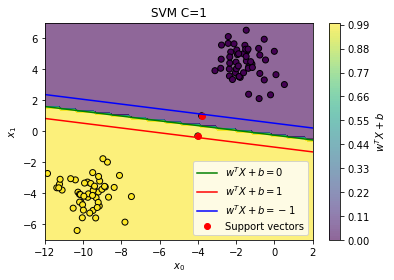

In [31]:
m = svm.SVC(C=1, kernel='linear')
m.fit(X, y)
a = Line((m.coef_ @ [x, y1] + m.intercept_)[0])

plus = Line(Eq((m.coef_ @ [x, y1] + m.intercept_)[0], 1))
minus = Line(Eq((m.coef_ @ [x, y1] + m.intercept_)[0], -1))


plt.contourf(xx, yy, m.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape), alpha=0.6, levels=100)
plt.colorbar().set_label('$w^T X + b$')
plt.scatter(*X.T, c=y, edgecolors='black')
plt.axline(np.array(a.p1.coordinates, float), np.array(a.p2.coordinates, float), color='green', label='$w^T X + b = 0$')
plt.axline(np.array(plus.p1.coordinates, float), np.array(plus.p2.coordinates, float), color='red', label='$w^T X + b = 1$')
plt.axline(np.array(minus.p1.coordinates, float), np.array(minus.p2.coordinates, float), color='blue', label='$w^T X + b = -1$')
plt.legend()
plt.title('SVM C=1')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$');
plt.scatter(*m.support_vectors_.T, color='red', label='Support vectors')
plt.legend()


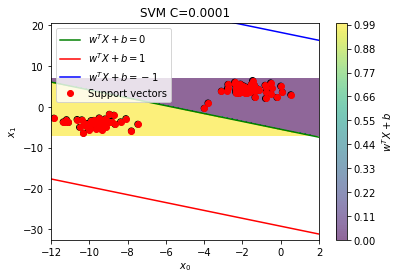

In [32]:
m = svm.SVC(C=0.0001, kernel='linear')
m.fit(X, y)
a = Line((m.coef_ @ [x, y1] + m.intercept_)[0])

plus = Line(Eq((m.coef_ @ [x, y1] + m.intercept_)[0], 1))
minus = Line(Eq((m.coef_ @ [x, y1] + m.intercept_)[0], -1))
plt.contourf(xx, yy, m.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape), alpha=0.6, levels=100)
plt.colorbar().set_label('$w^T X + b$')
plt.scatter(*X.T, c=y, edgecolors='black')
plt.axline(np.array(a.p1.coordinates, float), np.array(a.p2.coordinates, float), color='green', label='$w^T X + b = 0$')
plt.axline(np.array(plus.p1.coordinates, float), np.array(plus.p2.coordinates, float), color='red', label='$w^T X + b = 1$')
plt.axline(np.array(minus.p1.coordinates, float), np.array(minus.p2.coordinates, float), color='blue', label='$w^T X + b = -1$')
plt.legend()
plt.title('SVM C=0.0001')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$');
plt.scatter(*m.support_vectors_.T, color='red', label='Support vectors')
plt.legend()

## Dual problem

SVM agirlik optmizasyonunda aslen yukaida verilen problemin duali cozulmektedir.

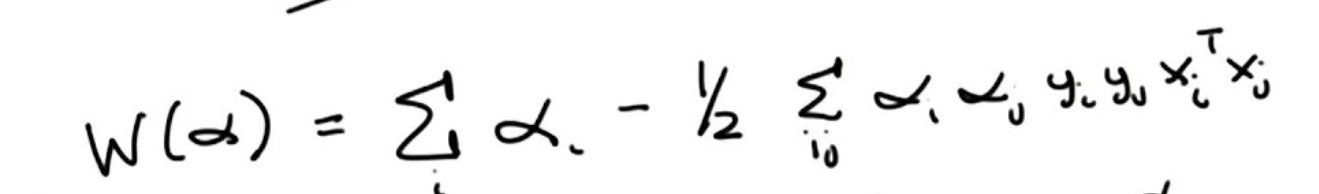

$$W(\alpha) = \sum_{i}{\alpha_i} - \frac{1}{2} \sum_{ij}{\alpha_i \alpha_j y_i y_j x_i^T x_j}$$

Fonksiyonda iki noktaya dikkat cekebiliriz:
- $\alpha_i$:
    : Her boyuta  degil, her ornege ait bir agirlik bulunmakta
- $x_i^T x_j$: Her bir ornegin birbiriyle capraz carpimi, bir nevi benzerlik hesaplamasi.

Esasen, her ornege ait bir katsayi bulunsa da bunlarin cogu 0 olup, katsayisi 0'dan farkli olan ornekler "destek vektoru" olarak isimlendirilmektedir.

Asagida dual katsayilari ve bunlarin alternatif olarak nasil kullanilabilecegini gorebilirsiniz:

**Not:** Lineer kernele ozel olarak, bu dual katsayilardan asil ornek uzayina tekabul eden katsayilar **$W$** bulunabilir.

In [33]:
m.decision_function([[4,4]])

array([-0.56066329])

In [34]:
[[4, 4]] @ m.coef_.T + m.intercept_

array([[-0.56066329]])

In [35]:
m.coef_

array([[-0.04060944, -0.0421203 ]])

In [36]:
m.dual_coef_

array([[-0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001,
        -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001,
        -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001,
        -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001,
        -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001,
        -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001,
        -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001,
        -0.0001, -0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,
         0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,
         0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,
         0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,
         0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,
         0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,
         0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,  0.0001,
      

In [37]:
m.support_vectors_.shape

(102, 2)

In [38]:
[[4, 4]] @ m.support_vectors_.T @ m.dual_coef_.T + m.intercept_

array([[-0.56066329]])

**Not:** Diger cekirdek donusumlerinde (RBF, poly, ...) bu mumkun degildir, cunku artik esas ornek uzayinda $w^T X + b$ gibi lineer bir sinir yoktur.

In [39]:
try:
    svm.SVC().fit(X, y).coef_
except Exception as e:
    print(e)

coef_ is only available when using a linear kernel


---

## Non-lineer karar sinirlari ve cekirdek donusumu

### Kernel trick

In [40]:
X, y = datasets.make_circles(noise=0.04, factor=0.4, random_state=42)
X = X[y.argsort()]
y = y[y.argsort()]

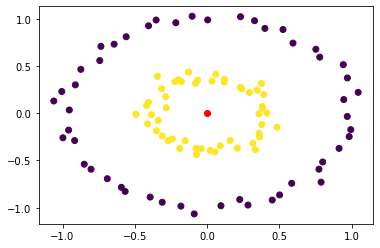

In [41]:
plt.scatter(*X.T, c=y)
plt.scatter(0, 0, color='red')

In [42]:
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

In [43]:
m = svm.SVC(C=10, kernel='linear')
m.fit(X, y)

SVC(C=10, kernel='linear')

No handles with labels found to put in legend.


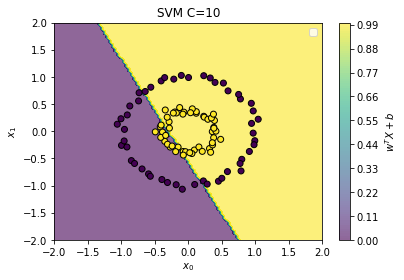

In [44]:
plt.contourf(xx, yy, m.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape), alpha=0.6, levels=100)
plt.colorbar().set_label('$w^T X + b$')
plt.scatter(*X.T, c=y, edgecolors='black')
plt.legend()
plt.title('SVM C=10')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$');

Esas ornek uzayi yerine, ornekleri yeni bir uzaya **haritalayabilir** miydik?

*Ornek donusum: orijine uzaklik*

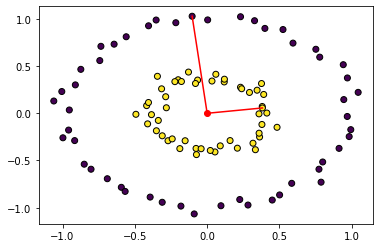

In [45]:
plt.scatter(*X.T, c=y, edgecolors='black')
plt.scatter(0, 0, color='red');
plt.plot([0, X[0, 0]], [0, X[0, 1]], color='red', label='$d_0$')
plt.plot([0, X[-1, 0]], [0, X[-1, 1]], color='red', label='$d_0$')


In [46]:
distances = ((X - [[0, 0]])**2).sum(axis=1)

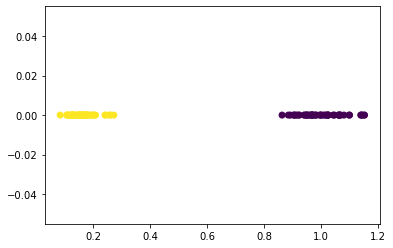

In [47]:
plt.scatter(distances, [0]*y.shape[0], c=y)

Artik problem lineer olarak cozulebilir mi?

Capraz carpima geri donus:

In [48]:
u = np.array([1, 1])

v = np.array([0.8, 0.6])
z = np.array([-0.1, 0.1])
q = np.array([-1., -0.75])
w = np.array([-1, -1])

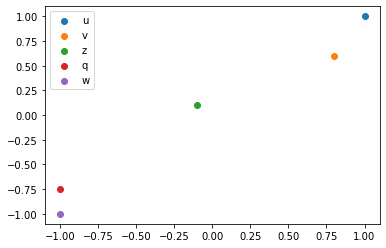

In [49]:
plt.scatter(*u, label='u')
plt.scatter(*v, label='v')
plt.scatter(*z, label='z')
plt.scatter(*q, label='q')
plt.scatter(*w, label='w')
plt.legend()

In [50]:
u@v

1.4

In [51]:
u@z

0.0

In [52]:
u@w

-2

In [53]:
import seaborn as sns
import pandas as pd

In [54]:
U = np.array([u, v, z, q, w])

In [55]:
U @ U.T

array([[ 2.    ,  1.4   ,  0.    , -1.75  , -2.    ],
       [ 1.4   ,  1.    , -0.02  , -1.25  , -1.4   ],
       [ 0.    , -0.02  ,  0.02  ,  0.025 ,  0.    ],
       [-1.75  , -1.25  ,  0.025 ,  1.5625,  1.75  ],
       [-2.    , -1.4   ,  0.    ,  1.75  ,  2.    ]])

Text(0.5, 1.0, '$U U^T$')

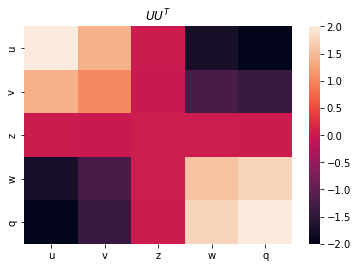

In [56]:
sns.heatmap(pd.DataFrame(U @ U.T, index=list('uvzwq'), columns=list('uvzwq')))
plt.title("$U U^T$")

In [57]:
from sklearn import metrics

Peki orijin yerine referans noktalarin secimini SVM'e birakabilir miyiz?

Potansiyel referans noktalari? her zaman oldugu gibi vektorlerin kendileri. Referans olarak secilenler destek vektoru olacak.

Baska bir ornek haritalama: $(XX^T)^2$

In [58]:
def haritala(X):
    return (X @ X.T) ** 2

Girdi datasina bu donusumu uygulayip yine lineer bir sekilde cozmeyi deneyelim.

In [59]:
X.shape

(100, 2)

In [60]:
haritala(X).shape

(100, 100)

In [61]:
m = svm.SVC(C=10, kernel='linear')
m.fit(haritala(X), y)

SVC(C=10, kernel='linear')

No handles with labels found to put in legend.


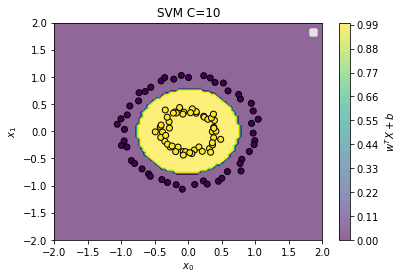

In [62]:
plt.contourf(xx, yy, m.predict(((np.array([xx.ravel(), yy.ravel()]).T)@X.T)**2).reshape(xx.shape), alpha=0.6, levels=100)
plt.colorbar().set_label('$w^T X + b$')
plt.scatter(*X.T, c=y, edgecolors='black')
plt.legend()
plt.title('SVM C=10')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$');

Muazzam. Su anda aslinda polinomiyel cekirdek donusumun gerceklestirdik.

## RBF -radial basis function

Iki nokta arasindaki benzerligi $[0, 1]$ araligina haritalamak isteseydiniz ne yapardiniz?

Datasetten 4 ornek nokta secelim:

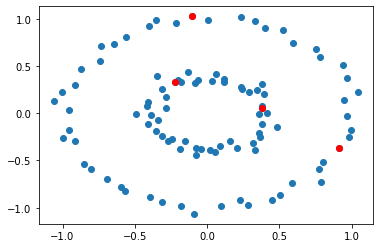

In [63]:
plt.scatter(*X.T)
plt.scatter(*X[[0,1,98,99]].T, color='red')

Gaussian fonksiyonu, benzerlik icin uygun bir fonksiyon olabilir mi?

$$exp(-\frac{||x-l||^2}{2\sigma^2})$$

- $x$: sorgu noktasi
- $l$: referans noktasi
- $\sigma$: gaussian'in olcegi

In [64]:
def rbf(x, l, sigma):
    dist = np.linalg.norm(x - l)**2
    return exp(-dist/2/sigma**2)

Simdi bu noktalardan birini referans olarak secip digerlerinin buna benzerliklerini inceleyelim:

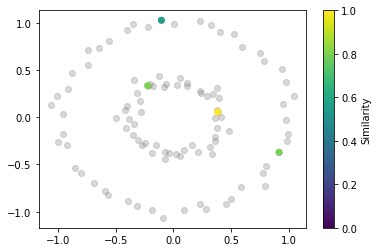

In [65]:
plt.scatter(*X.T, color='gray', alpha=0.3)
plt.scatter(*X[[0,1,98,99]].T, c=[rbf(X[99], X[i], 1.0) for i in [0, 1, 98, 99]], vmin=0, vmax=1)
plt.colorbar().set_label("Similarity")

Benzerlik, $\sigma$ parametresinin secimine gore de sekillenmektedir:

In [66]:
@interact
def vizsig(sig=(0.1, 2.0, 0.3)):
    plt.scatter(*X.T, color='gray', alpha=0.3)
    plt.scatter(*X.T, c=[rbf(X[99], X[i],sig) for i in range(100)], vmin=0, vmax=1)
    plt.scatter(*X[99], color='red', label='ref')
    plt.legend()
    plt.colorbar().set_label("Similarity")
    plt.title(f"$\sigma={sig}$");

interactive(children=(FloatSlider(value=0.9999999999999999, description='sig', max=2.0, min=0.1, step=0.3), Ou…

RBF cekirdek donusumunu tum datasete uygulayarak benzerlikleri isi haritasi uzerinde inceleyelim:

In [67]:
kernel = metrics.pairwise.rbf_kernel(X)

In [68]:
X.shape

(100, 2)

In [69]:
kernel.shape

(100, 100)

<AxesSubplot:>

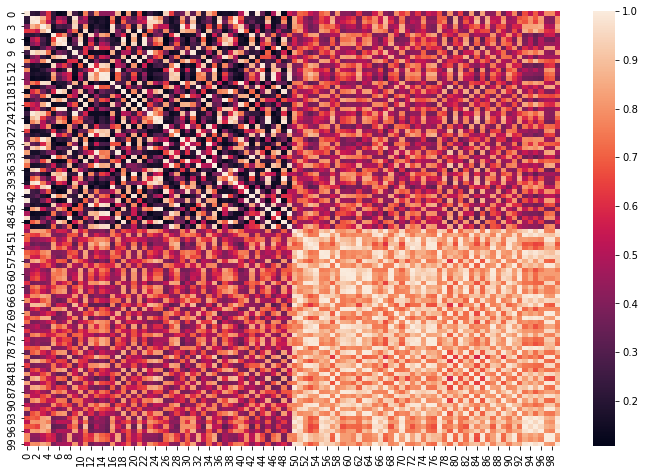

In [70]:
plt.figure(figsize=(12, 8))
sns.heatmap(kernel)

Benzerliklerdeki patern acikca gorulebiliyor. Peki rastgele sececegimiz 3 referans noktasina olan benzerlikler datayi lineer bir karar siniriyla ayirmamizi saglayabilir miydi?

In [71]:
%matplotlib inline
@interact
def kernelviz(elev=(-90,90,5), azim=(0,180,5)):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(kernel[:, 62], kernel[:, 34], kernel[:, 10], c=y)
    ax.view_init(elev, azim)

interactive(children=(IntSlider(value=0, description='elev', max=90, min=-90, step=5), IntSlider(value=90, des…

In [72]:
%matplotlib qt5
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(kernel[:, 62], kernel[:, 34], kernel[:, 10], c=y)

Neyse ki bu cekirdek donusumleri SVM'de varsayilan olarak implemente edilmistir. `kernel` parametresini kontrol ederek istedigimiz donusumu uygulayaibliriz.

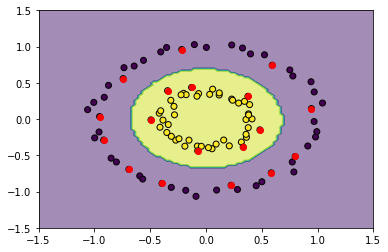

In [73]:
%matplotlib inline
circ_svm = svm.SVC(kernel='rbf', C=1)

circ_svm.fit(X, y)

xx , yy = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))

xx.shape

yy.shape

zz = circ_svm.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape)

plt.contourf(xx, yy, zz, alpha=0.5)
plt.scatter(*X.T, c=y, edgecolors='black')
plt.scatter(*circ_svm.support_vectors_.T, color='red')

<AxesSubplot:>

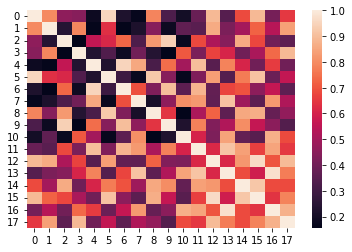

In [75]:
sns.heatmap(metrics.pairwise.rbf_kernel(circ_svm.support_vectors_))

### Olcekler

Orjinal verisetimizin olceginin her iki boyutta da 1000 kat daha buyuk oldugunu farz edelim:

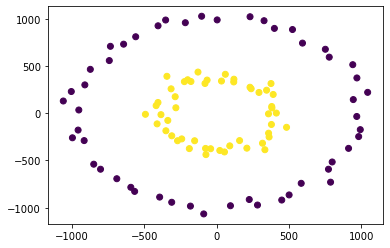

In [76]:
plt.scatter(*(X * 1000).T, c=y)

Bu kosulda RBF donusumunu uyguladigimizda ilk gozlemimizden cok farkli bir resim goruyoruz.

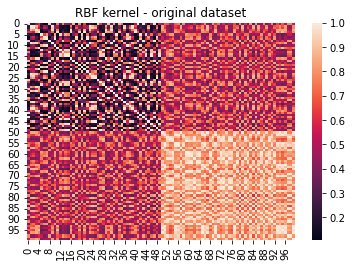

In [77]:
sns.heatmap(metrics.pairwise.rbf_kernel(X))
plt.title("RBF kernel - original dataset");

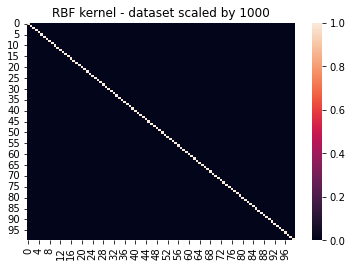

In [78]:
sns.heatmap(metrics.pairwise.rbf_kernel(X*1000))
plt.title("RBF kernel - dataset scaled by 1000");

Benzer bir gozlemi 1e-3 ile olceklenmis datasetine RBF donusumunu uyguladigimizda da goruyoruz:

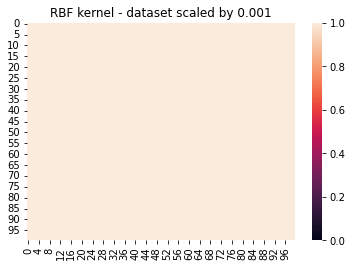

In [79]:
sns.heatmap(metrics.pairwise.rbf_kernel(X*1e-3), vmin=0, vmax=1)
plt.title("RBF kernel - dataset scaled by 0.001");

1e-8 olceginde ise benzerlikler yok oluyor.

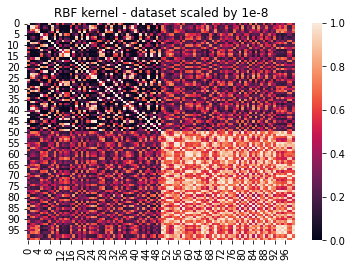

In [80]:
sns.heatmap(metrics.pairwise.rbf_kernel(X*1e-8, gamma=1e16),  vmin=0, vmax=1)
plt.title("RBF kernel - dataset scaled by 1e-8");

Bu gozlemlere gore, RBF cekirdek donusumunu uygularken degiskenlerin olcegine dikkat etmemiz gerektigi sonucuna varabiliriz. Degiskenlerin olcegine gore `gamma` parametresi ayarlanabilir. `gamma`, `sigma` ile ters orantili olarak degismekte oldugunu dusunebiliriz.

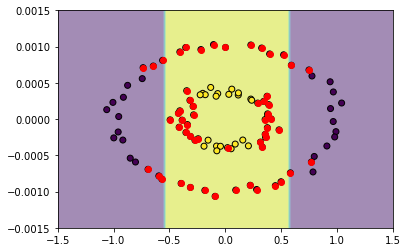

In [81]:
circ_svm = svm.SVC(kernel='rbf')

circ_svm.fit(X*[1, .001], y)

xx , yy = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
xx *= 1
yy *= .001
xx.shape

yy.shape

zz = circ_svm.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape)

plt.contourf(xx, yy, zz, alpha=0.5)
plt.scatter(*(X*[1, .001]).T, c=y, edgecolors='black')
plt.scatter(*circ_svm.support_vectors_.T, color='red')

In [82]:
from sklearn import preprocessing

In [83]:
pd.DataFrame(preprocessing.scale(X*[1, .001])).describe()

,0,1
count,1.000000e+02,1.000000e+02
mean,5.551115e-18,1.526557e-17
std,1.005038e+00,1.005038e+00
min,-1.975170e+00,-1.967928e+00
25%,-6.569429e-01,-6.843980e-01
50%,-3.900746e-02,-3.605155e-04
75%,6.965692e-01,6.392564e-01
max,1.937613e+00,1.903481e+00


Asagida olcegi 1000 artirilmis veri setinde RBF'in dogru calismasi icin `gamma`yi kucultuyoruz:

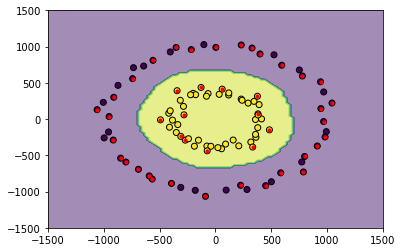

In [87]:
circ_svm = svm.SVC(kernel='rbf', gamma=0.00001)

circ_svm.fit(X*1000, y)

xx , yy = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
xx *= 1000
yy *= 1000
xx.shape

yy.shape

zz = circ_svm.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape)

plt.contourf(xx, yy, zz, alpha=0.5)
plt.scatter(*(X*1000).T, c=y, edgecolors='black')
plt.scatter(*circ_svm.support_vectors_.T, color='red', s=10)

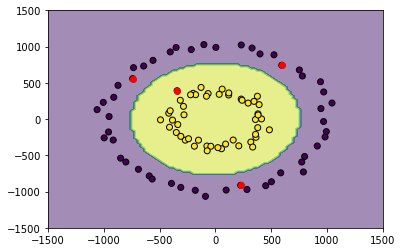

In [88]:
circ_svm = svm.SVC(kernel='poly', gamma=0.00001, degree=2, )

circ_svm.fit(X*1000, y)

xx , yy = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
xx *= 1000
yy *= 1000
xx.shape

yy.shape

zz = circ_svm.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape)

plt.contourf(xx, yy, zz, alpha=0.5)
plt.scatter(*(X*1000).T, c=y, edgecolors='black')
plt.scatter(*circ_svm.support_vectors_.T, color='red')

Simdi daha vahim bir durumu inceleyelim; degiskenlerimizden biri +- 1000 olceginde degisirken digeri +- 1 olceginde degissin.

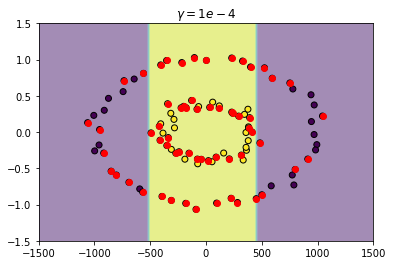

In [90]:
circ_svm = svm.SVC(kernel='rbf', gamma=0.0001)

circ_svm.fit(X*[1000, 1], y)

xx , yy = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
xx *= 1000
yy *= 1
xx.shape

yy.shape

zz = circ_svm.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape)

plt.contourf(xx, yy, zz, alpha=0.5)
plt.scatter(*(X*[1000, 1]).T, c=y, edgecolors='black')
plt.scatter(*circ_svm.support_vectors_.T, color='red')
plt.title('$\gamma=1e-4$');

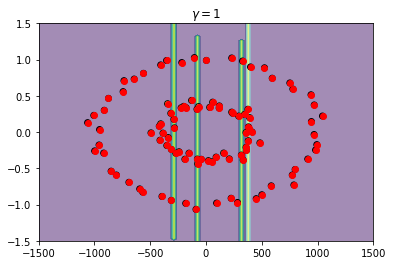

In [91]:
circ_svm = svm.SVC(kernel='rbf', gamma=1)

circ_svm.fit(X*[1000, 1], y)

xx , yy = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
xx *= 1000
yy *= 1
xx.shape

yy.shape

zz = circ_svm.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape)

plt.contourf(xx, yy, zz, alpha=0.5)
plt.scatter(*(X*[1000, 1]).T, c=y, edgecolors='black')
plt.scatter(*circ_svm.support_vectors_.T, color='red')
plt.title('$\gamma=1$');

`gamma` parametresini degistirerek bir yere varmak mumkun olmadi. Tum degiskenleri ayni olcege getirmek gerekliligini hissediyoruz.

In [92]:
from sklearn import preprocessing

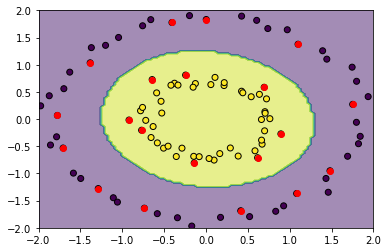

In [93]:
circ_svm = svm.SVC(kernel='rbf', gamma=1)

circ_svm.fit(preprocessing.scale(X*[1000, 1]), y)

xx , yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
xx *= 1
yy *= 1
xx.shape

yy.shape

zz = circ_svm.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape)

plt.contourf(xx, yy, zz, alpha=0.5)
plt.scatter(*(preprocessing.scale(X*[1000, 1])).T, c=y, edgecolors='black')
plt.scatter(*circ_svm.support_vectors_.T, color='red')

### RBF SVM lineer ayrimin mumkun oldugu datasetlerde kullanilabilir mi?

In [94]:
X, y = datasets.make_blobs(random_state=1, centers=2,)
X = X.tolist() + [[-4, 1], [-4, -0.3]]
X = np.array(X)
y = y.tolist() + [0, 1]
y = np.array(y)

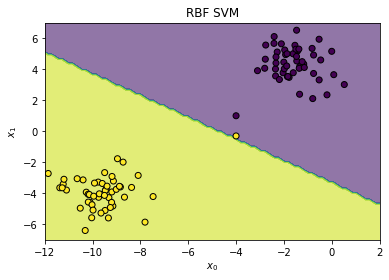

In [105]:
circ_svm = svm.SVC(kernel='linear', gamma=0.01, C=0.1, decision_function_shape='ovr')

circ_svm.fit(X, y)

xx, yy = np.meshgrid(np.linspace(-12, 2, 100), np.linspace(-7, 7, 100))

plt.contourf(xx, yy, circ_svm.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape), alpha=0.6)
plt.scatter(*X.T, c=y, edgecolors='black')
plt.title('RBF SVM')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$');

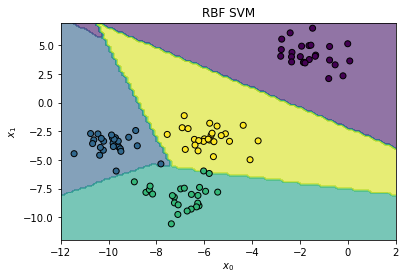

In [108]:
X, y = datasets.make_blobs(random_state=1, centers=4)
circ_svm = svm.SVC(kernel='linear', gamma=0.01, C=0.1, decision_function_shape='ovr')

circ_svm.fit(X, y)

xx, yy = np.meshgrid(np.linspace(-12, 2, 100), np.linspace(-12, 7, 100))

plt.contourf(xx, yy, circ_svm.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape), alpha=0.6)
plt.scatter(*X.T, c=y, edgecolors='black')
plt.title('RBF SVM')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$');

In [111]:
X, y = datasets.make_blobs(random_state=1, centers=2, n_samples=100000)
circ_svm = svm.SVC(kernel='rbf', gamma=0.01, C=0.1, decision_function_shape='ovr')

circ_svm.fit(X, y)

# xx, yy = np.meshgrid(np.linspace(-12, 2, 100), np.linspace(-12, 7, 100))

# plt.contourf(xx, yy, circ_svm.predict(np.array([xx.ravel(), yy.ravel()]).T).reshape(xx.shape), alpha=0.6)
# plt.scatter(*X.T, c=y, edgecolors='black')
# plt.title('RBF SVM')
# plt.xlabel('$x_0$')
# plt.ylabel('$x_1$');

SVC(C=0.1, gamma=0.01)